In [35]:
import kaggle
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Embedding, Flatten, SimpleRNN, LSTM 
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
#save requiremenst in text file:
!pip freeze | findstr "==" > requirements.txt

In [3]:
#download dataset from kaggle:
kaggle.api.authenticate()
kaggle.api.dataset_download_files('abdelmalekeladjelet/sentiment-analysis-dataset', path='.', unzip='True')

Dataset URL: https://www.kaggle.com/datasets/abdelmalekeladjelet/sentiment-analysis-dataset


In [4]:
#initialise dataframe:
df = pd.read_csv('./sentiment_data.csv', encoding='utf-8')
df.head()

Unnamed: 0                                            Comment  Sentiment
0           0  lets forget apple pay required brand new iphon...          1
1           1  nz retailers don’t even contactless credit car...          0
2           2  forever acknowledge channel help lessons ideas...          2
3           3  whenever go place doesn’t take apple pay doesn...          0
4           4  apple pay convenient secure easy use used kore...          2

In [5]:
df.shape

(241145, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241145 entries, 0 to 241144
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  241145 non-null  int64 
 1   Comment     240928 non-null  object
 2   Sentiment   241145 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 5.5+ MB


In [7]:
df['Comment'] = df['Comment'].astype('string')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241145 entries, 0 to 241144
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  241145 non-null  int64 
 1   Comment     240928 non-null  string
 2   Sentiment   241145 non-null  int64 
dtypes: int64(2), string(1)
memory usage: 5.5 MB


In [8]:
df.isnull().sum()

Unnamed: 0      0
Comment       217
Sentiment       0
dtype: int64

In [9]:
#drop nulls:
df = df.dropna(subset=['Comment'], axis=0)
df.isnull().sum()

Unnamed: 0    0
Comment       0
Sentiment     0
dtype: int64

In [10]:
#drop unnamed colums:
df = df.drop('Unnamed: 0', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240928 entries, 0 to 241144
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Comment    240928 non-null  string
 1   Sentiment  240928 non-null  int64 
dtypes: int64(1), string(1)
memory usage: 5.5 MB


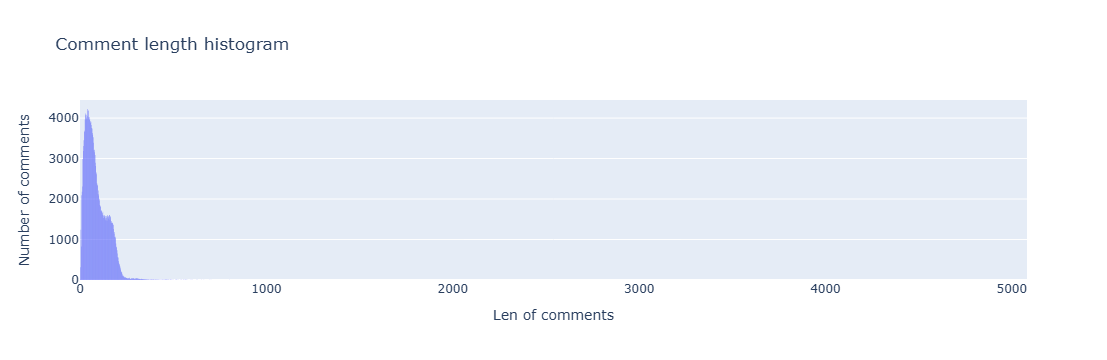

In [50]:
#Check length of comments:
df['CommentLength'] = df['Comment'].str.len()

# #plot histogram:
fig = px.histogram(df, x='CommentLength', title='Comment length histogram', color_discrete_sequence=['#556B2F'])

fig.update_layout(
    xaxis_title='Len of comments',
    yaxis_title='Number of comments',
    bargap=0.1
)

fig.show()

In [12]:
#check values od Sentiment:
df['Sentiment'].value_counts()

Sentiment
2    103046
1     82777
0     55105
Name: count, dtype: int64

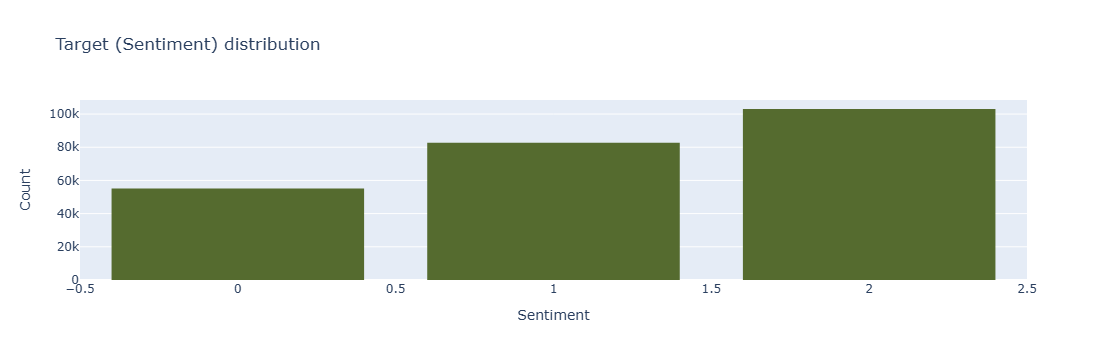

In [54]:
#make a histplot of target:
fig = px.histogram(df, x='Sentiment', title='Target (Sentiment) distribution', color_discrete_sequence=['#556B2F'])

fig.update_layout(
    xaxis_title='Sentiment',
    yaxis_title='Count',
    bargap=0.2
)

fig.show()

In [65]:
#split data info training, testing and validation sets:
X = df['Comment']
y = df['Sentiment']

#Extract train set:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

#Extract testing and validation sets from temp sets:
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)                                                 

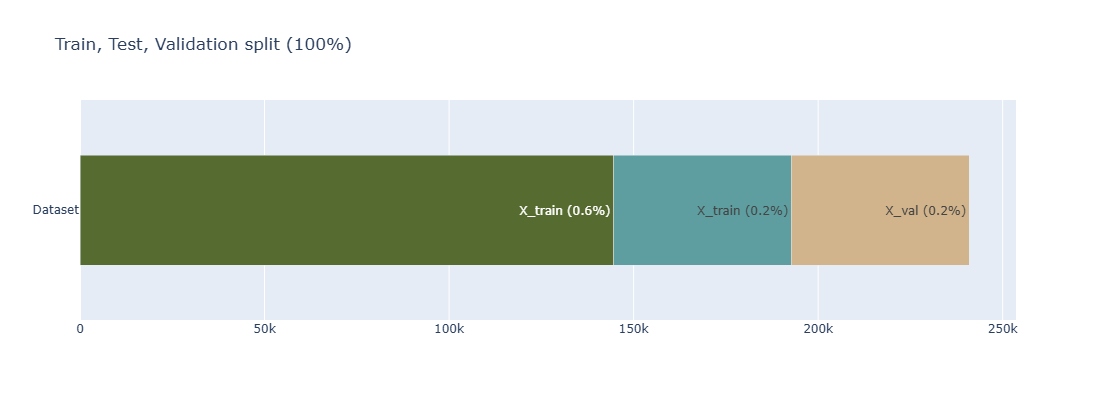

In [51]:
#Check balance between train, temp and validation sets:
fig = go.Figure(
    )

fig.add_trace(go.Bar(
    name='X_train',
    x=[len(X_train)],
    y=['Dataset'],
    marker_color='#556B2F',
    text=f'X_train ({round(len(X_train) / len(df), 2)}%)',
    textposition='inside',
    width=0.5,
    orientation='h'
))

fig.add_trace(go.Bar(
    name='X_test',
    x=[len(X_test)],
    y=['Dataset'], 
    marker_color='#5F9EA0',
    text=f'X_train ({round(len(X_test) / len(df), 2)}%)',
    textposition='inside',
    width=0.5,
    orientation='h'
))

fig.add_trace(go.Bar(
    name='X_val',
    x=[len(X_val)], 
    y=['Dataset'], 
    marker_color='#D2B48C',
    text=f'X_val ({round(len(X_val) / len(df), 2)}%)',
    textposition='inside',
    width=0.5,
    orientation='h'
))

fig.update_layout(
    barmode='stack',
    title='Train, Test, Validation split (100%)',
    width=800, 
    height=400,
    showlegend=False
)

fig.show()

In [66]:
#initialise tokenizer:
maxlen = 100 #set min len of comments to 100 words
num_words = 50000 #choose 50000 the most common words
embedding_dim = 100

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

In [67]:
#convert each training comment into sequence od integer word indices:
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)
val_sequences = tokenizer.texts_to_sequences(X_val)

In [68]:
#shorten comments to 100 characters (X_train):
X_train = pad_sequences(train_sequences, maxlen=maxlen)
X_train.shape

(144556, 100)

In [69]:
#shorten comments to 100 characters (X_test):
X_test = pad_sequences(test_sequences, maxlen=maxlen)
X_test.shape

(48186, 100)

In [70]:
#shorten comments to 100 characters (X_val):
X_val = pad_sequences(val_sequences, maxlen=maxlen)
X_val.shape

(48186, 100)

### Make simple ANN:

In [20]:
#initialise structure of NN:
model1 = Sequential()
model1.add(Embedding(num_words, embedding_dim))
model1.add(Flatten())
model1.add(Dense(16, activation='relu'))
model1.add(Dense(3, activation='softmax'))
model1.build(input_shape=(None, 100))
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 100)            │       5,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │         160,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,160,067 (19.68 MB)

 Trainable params: 5,160,067 (19.68 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
#compile model:
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
#train NN:
history1 = model1.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
4518/4518 ━━━━━━━━━━━━━━━━━━━━ 196s 43ms/step - accuracy: 0.6671 - loss: 0.7628 - val_accuracy: 0.8078 - val_loss: 0.5160
Epoch 2/5
4518/4518 ━━━━━━━━━━━━━━━━━━━━ 192s 43ms/step - accuracy: 0.8805 - loss: 0.3370 - val_accuracy: 0.8139 - val_loss: 0.5218
Epoch 3/5
4518/4518 ━━━━━━━━━━━━━━━━━━━━ 194s 43ms/step - accuracy: 0.9494 - loss: 0.1561 - val_accuracy: 0.8036 - val_loss: 0.6629
Epoch 4/5
4518/4518 ━━━━━━━━━━━━━━━━━━━━ 191s 42ms/step - accuracy: 0.9743 - loss: 0.0814 - val_accuracy: 0.7970 - val_loss: 0.8486
Epoch 5/5
4518/4518 ━━━━━━━━━━━━━━━━━━━━ 189s 42ms/step - accuracy: 0.9840 - loss: 0.0510 - val_accuracy: 0.7940 - val_loss: 1.0411


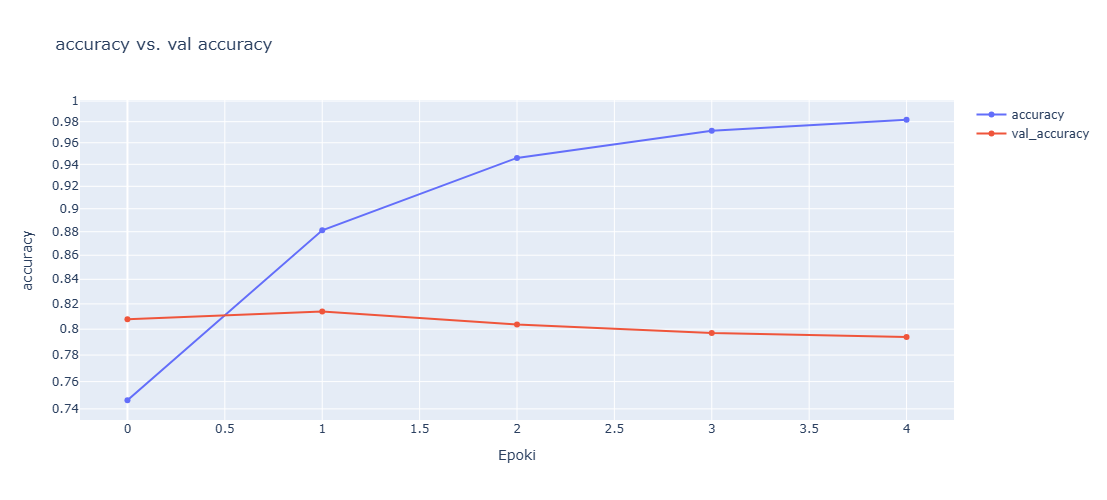

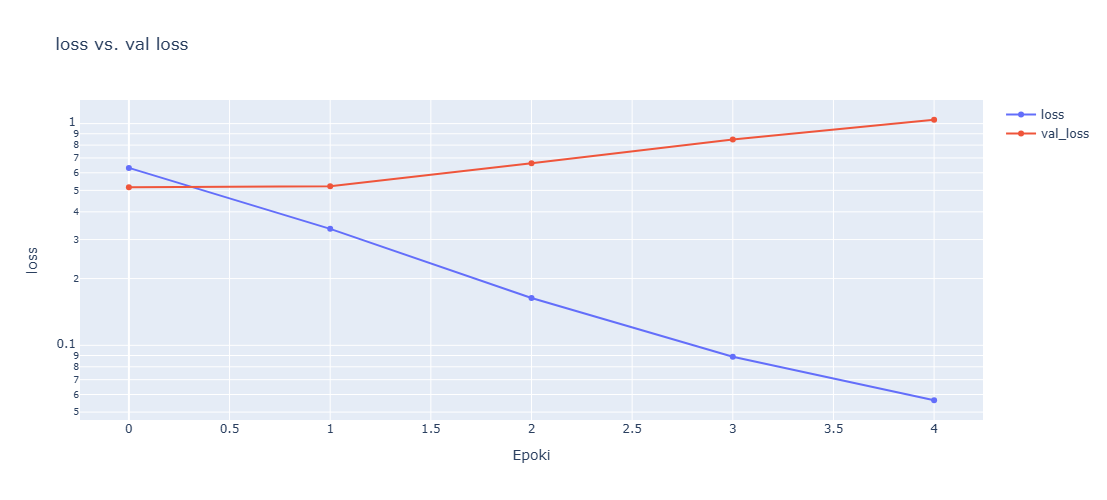

In [23]:
def plot_hist(history):
    import pandas as pd
    import plotly.graph_objects as go
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='accuracy vs. val accuracy', xaxis_title='Epoki', yaxis_title='accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='loss vs. val loss', xaxis_title='Epoki', yaxis_title='loss', yaxis_type='log')
    fig.show()

plot_hist(history1)

### Add RNN layer:

In [24]:
#initialise structure of NN:
model2 = Sequential()
model2.add(Embedding(num_words, embedding_dim))
model2.add(SimpleRNN(16))
model2.add(Dense(3, activation='softmax'))
model2.build(input_shape=(None, 100))
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 100)            │       5,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 16)                  │           1,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,001,923 (19.08 MB)

 Trainable params: 5,001,923 (19.08 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
#compile model:
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [26]:
#training model:
history2 = model2.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
4518/4518 ━━━━━━━━━━━━━━━━━━━━ 242s 53ms/step - accuracy: 0.6663 - loss: 0.7887 - val_accuracy: 0.7875 - val_loss: 0.5961
Epoch 2/5
4518/4518 ━━━━━━━━━━━━━━━━━━━━ 241s 53ms/step - accuracy: 0.8428 - loss: 0.4550 - val_accuracy: 0.8049 - val_loss: 0.5657
Epoch 3/5
4518/4518 ━━━━━━━━━━━━━━━━━━━━ 264s 58ms/step - accuracy: 0.8952 - loss: 0.3102 - val_accuracy: 0.7872 - val_loss: 0.6153
Epoch 4/5
4518/4518 ━━━━━━━━━━━━━━━━━━━━ 346s 64ms/step - accuracy: 0.9226 - loss: 0.2343 - val_accuracy: 0.7791 - val_loss: 0.6953
Epoch 5/5
4518/4518 ━━━━━━━━━━━━━━━━━━━━ 386s 78ms/step - accuracy: 0.9430 - loss: 0.1760 - val_accuracy: 0.7741 - val_loss: 0.7413


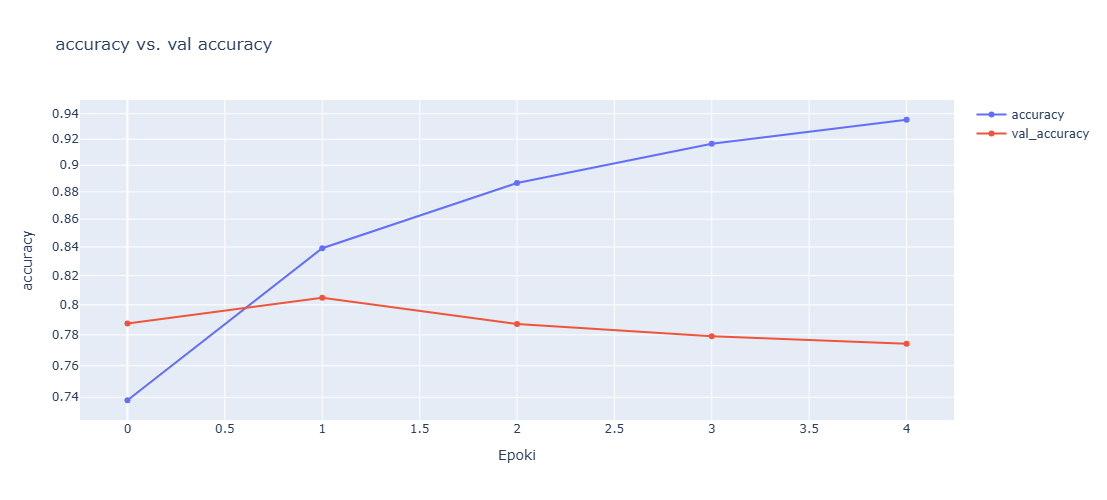

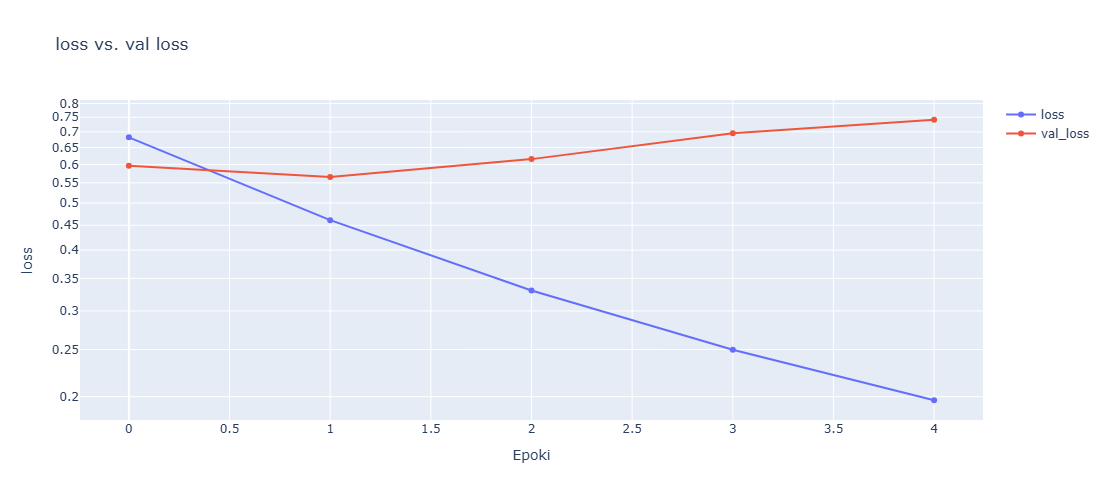

In [27]:
plot_hist(history2)

### Add  LSTM layer:

In [28]:
#implement structure od NN:
model3 = Sequential()
model3.add(Embedding(num_words, embedding_dim))
model3.add(LSTM(16))
model3.add(Dense(3, activation='softmax'))
model3.build(input_shape=(None, 100))
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 100)            │       5,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 16)                  │           7,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,007,539 (19.10 MB)

 Trainable params: 5,007,539 (19.10 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
#compile model:
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
history3 = model3.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
4518/4518 ━━━━━━━━━━━━━━━━━━━━ 432s 95ms/step - accuracy: 0.7155 - loss: 0.6849 - val_accuracy: 0.8342 - val_loss: 0.4536
Epoch 2/5
4518/4518 ━━━━━━━━━━━━━━━━━━━━ 315s 70ms/step - accuracy: 0.8686 - loss: 0.3615 - val_accuracy: 0.8427 - val_loss: 0.4413
Epoch 3/5
4518/4518 ━━━━━━━━━━━━━━━━━━━━ 312s 69ms/step - accuracy: 0.9162 - loss: 0.2426 - val_accuracy: 0.8412 - val_loss: 0.4736
Epoch 4/5
4518/4518 ━━━━━━━━━━━━━━━━━━━━ 309s 68ms/step - accuracy: 0.9444 - loss: 0.1662 - val_accuracy: 0.8362 - val_loss: 0.5498
Epoch 5/5
4518/4518 ━━━━━━━━━━━━━━━━━━━━ 302s 67ms/step - accuracy: 0.9623 - loss: 0.1123 - val_accuracy: 0.8238 - val_loss: 0.6410


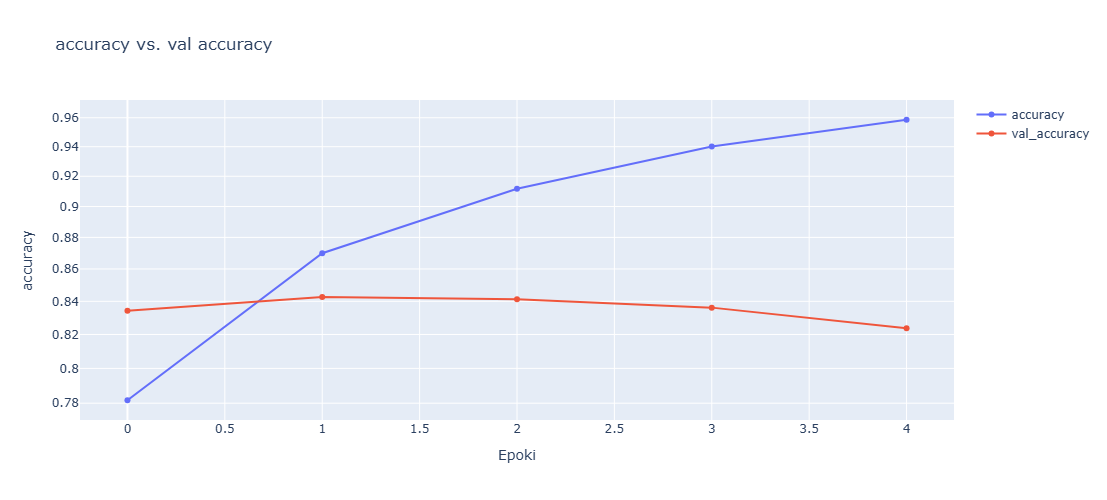

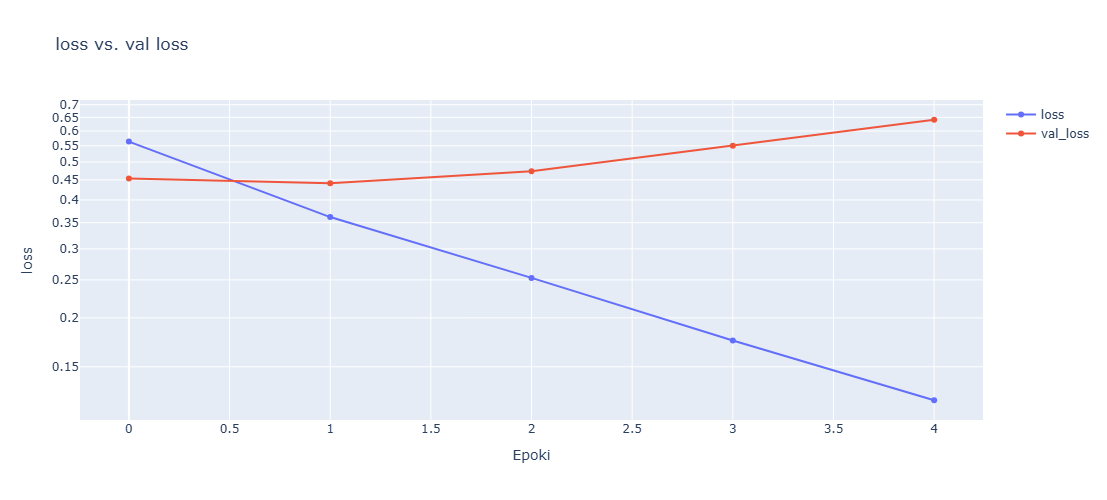

In [31]:
plot_hist(history3)

### Train again the best model (with LSTM layer) using Earli Stopping:

In [39]:
#add early stopping:
es = EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    restore_best_weights=True,
    verbose=True,
    mode='max'
)

In [40]:
#clone the best model (model3), compile and train again using early stopping:
model4 = clone_model(model3)

model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history4 = model4.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test), callbacks=[es])

Epoch 1/5
4518/4518 ━━━━━━━━━━━━━━━━━━━━ 438s 96ms/step - accuracy: 0.7138 - loss: 0.6886 - val_accuracy: 0.8320 - val_loss: 0.4566
Epoch 2/5
4518/4518 ━━━━━━━━━━━━━━━━━━━━ 418s 93ms/step - accuracy: 0.8690 - loss: 0.3609 - val_accuracy: 0.8401 - val_loss: 0.4441
Epoch 3/5
4518/4518 ━━━━━━━━━━━━━━━━━━━━ 398s 88ms/step - accuracy: 0.9115 - loss: 0.2506 - val_accuracy: 0.8374 - val_loss: 0.4836
Epoch 4/5
4518/4518 ━━━━━━━━━━━━━━━━━━━━ 429s 95ms/step - accuracy: 0.9408 - loss: 0.1746 - val_accuracy: 0.8347 - val_loss: 0.5582
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.


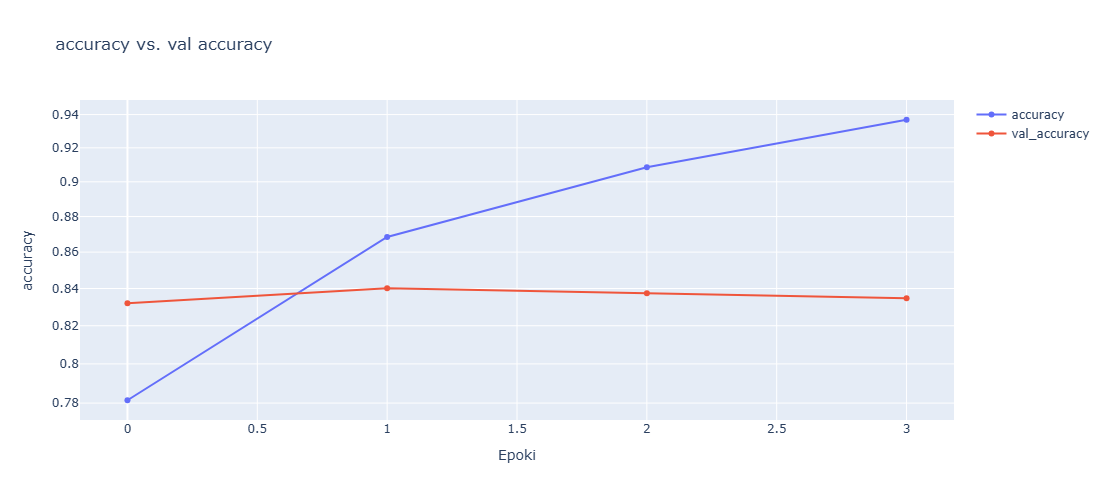

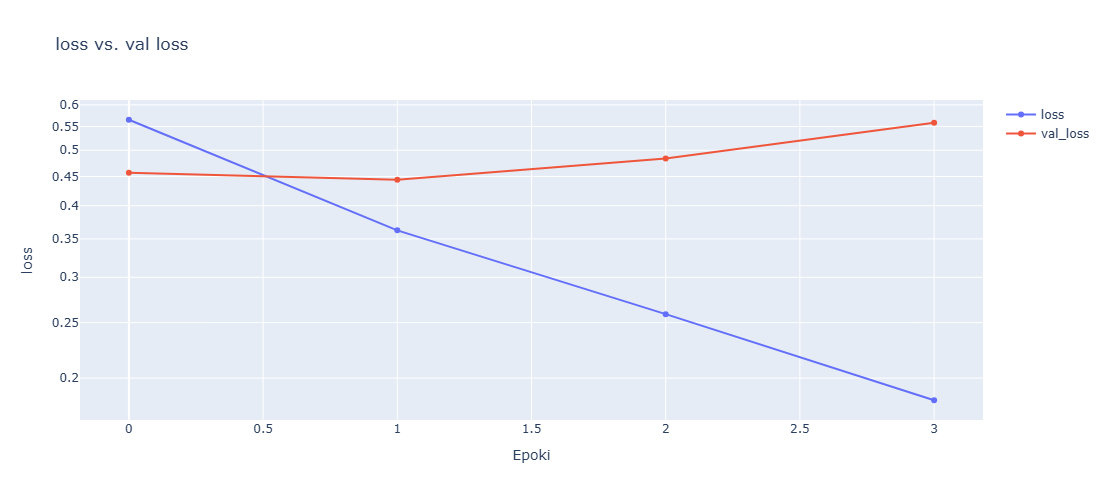

In [41]:
plot_hist(history4)

In [72]:
#evaluate model with unseen data:
val_loss, val_acc = model4.evaluate(X_val, y_val, verbose=1)
print(f'val los: {val_loss}')
print(f'val acc: {val_acc}')

1506/1506 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8369 - loss: 0.4499
val los: 0.44742998480796814
val acc: 0.8377537131309509


In [74]:
pip install shap


   ---------------------------------------- 0.0/545.2 kB ? eta -:--:--
   ---------------------------------------- 545.2/545.2 kB 3.0 MB/s eta 0:00:00


In [78]:
import shap
import numpy as np

# Bierzemy małą próbkę
X_explain = X_val[:200]

# Tworzymy explainer — uwaga, wymagany tf.Tensor lub numpy array
explainer = shap.GradientExplainer(model4, X_val[:200])

# Obliczamy SHAP
shap_values = explainer.shap_values(X_explain)

# Wizualizacja
shap.summary_plot(shap_values[0], X_explain)

C:\anaconda\Lib\site-packages\keras\src\models\functional.py:241: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_2
Received: inputs=['Tensor(shape=(200, 100))']

C:\anaconda\Lib\site-packages\keras\src\models\functional.py:241: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_2
Received: inputs=['Tensor(shape=(50, 100))']



ValueError: zero-dimensional arrays cannot be concatenated